In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-real/data/fake_cifake_images/641.png
/kaggle/input/fake-real/data/fake_cifake_images/173.png
/kaggle/input/fake-real/data/fake_cifake_images/815.png
/kaggle/input/fake-real/data/fake_cifake_images/491.png
/kaggle/input/fake-real/data/fake_cifake_images/718.png
/kaggle/input/fake-real/data/fake_cifake_images/709.png
/kaggle/input/fake-real/data/fake_cifake_images/889.png
/kaggle/input/fake-real/data/fake_cifake_images/379.png
/kaggle/input/fake-real/data/fake_cifake_images/780.png
/kaggle/input/fake-real/data/fake_cifake_images/248.png
/kaggle/input/fake-real/data/fake_cifake_images/94.png
/kaggle/input/fake-real/data/fake_cifake_images/480.png
/kaggle/input/fake-real/data/fake_cifake_images/236.png
/kaggle/input/fake-real/data/fake_cifake_images/771.png
/kaggle/input/fake-real/data/fake_cifake_images/675.png
/kaggle/input/fake-real/data/fake_cifake_images/340.png
/kaggle/input/fake-real/data/fake_cifake_images/48.png
/kaggle/input/fake-real/data/fake_cifake_images/51

In [2]:
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights

import os
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import glob
import copy
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
from thop import profile # For FLOPs calculation

In [4]:
train_real_dir = "/kaggle/input/fake-real/data/real_cifake_images"
train_fake_dir = "/kaggle/input/fake-real/data/fake_cifake_images"
test_dir = "/kaggle/input/fake-real/data/test"

In [5]:
# --- Hyperparameters and Configuration ---

# Set device (GPU or CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Model parameters
LEARNING_RATE = 0.001
BATCH_SIZE = 32 # Small batch size for mock data; increase for real dataset
NUM_EPOCHS = 35 # Increase for real training
IMG_SIZE = 224 # Input size for models like ResNet/EfficientNet
PATIENCE = 5 # For early stopping

# Data paths (pointing to our mock data)
TRAIN_REAL_DIR = train_real_dir
TRAIN_FAKE_DIR = train_fake_dir
TEST_DIR = test_dir

# Model save paths
RESNET_PATH = "best_resnet.pth"
EFFICIENTNET_PATH = "best_efficientnet.pth"
CUSTOM_CNN_PATH = "best_custom_cnn.pth"

Using device: cuda


In [6]:
class DeepfakeTrainDataset(Dataset):
    """Custom Dataset for loading real and fake training images."""
    def __init__(self, real_dir, fake_dir, transform=None):
        self.transform = transform
        self.image_files = []

        # Load real images (label 0)
        for filename in glob.glob(os.path.join(real_dir, "*.png")):
            self.image_files.append((filename, 0.0))

        # Load fake images (label 1)
        for filename in glob.glob(os.path.join(fake_dir, "*.png")):
            self.image_files.append((filename, 1.0))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, label = self.image_files[idx]
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image and label if loading fails
            image = Image.new("RGB", (IMG_SIZE, IMG_SIZE), color="black")
            label = 0.0 # Or handle as you see fit

        if self.transform:
            image = self.transform(image)

        # We need label as a float tensor for BCEWithLogitsLoss
        return image, torch.tensor(label, dtype=torch.float32)


class DeepfakeTestDataset(Dataset):
    """Custom Dataset for loading test images."""
    def __init__(self, test_dir, transform=None):
        self.transform = transform
        self.image_files = glob.glob(os.path.join(test_dir, "*.png"))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        filename = os.path.basename(img_path)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading test image {img_path}: {e}")
            image = Image.new("RGB", (IMG_SIZE, IMG_SIZE), color="black")

        if self.transform:
            image = self.transform(image)

        return image, filename

In [7]:
# --- Data Transforms ---
# Define normalization constants (standard for ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Data augmentation for training to prevent overfitting
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    normalize
])

# No augmentation for validation and testing
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize
])


In [8]:
# --- Create DataLoaders ---

# 1. Create the full training dataset
full_dataset = DeepfakeTrainDataset(TRAIN_REAL_DIR, TRAIN_FAKE_DIR, transform=train_transforms)

# 2. Split into training and validation sets (e.g., 80% train, 20% val)
total_size = len(full_dataset)
val_size = int(total_size * 0.2)
train_size = total_size - val_size

# Check if dataset is large enough to split
if train_size > 0 and val_size > 0:
    train_dataset, val_dataset_with_aug = random_split(full_dataset, [train_size, val_size])
    
    # IMPORTANT: We must apply validation transforms (no aug) to the validation set
    # We create a new Dataset object for validation using the indices from the split
    # This is a bit of a workaround but ensures no data augmentation leaks into validation
    val_dataset = DeepfakeTrainDataset(TRAIN_REAL_DIR, TRAIN_FAKE_DIR, transform=val_test_transforms)
    val_dataset.image_files = [full_dataset.image_files[i] for i in val_dataset_with_aug.indices]
else:
    print("Dataset too small to split. Using full dataset for both training and validation.")
    # This is not ideal, but necessary for our tiny mock dataset
    train_dataset = full_dataset
    val_dataset = DeepfakeTrainDataset(TRAIN_REAL_DIR, TRAIN_FAKE_DIR, transform=val_test_transforms)


print(f"Total training images: {len(train_dataset)}")
print(f"Total validation images: {len(val_dataset)}")

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# 4. Create Test DataLoader
test_dataset = DeepfakeTestDataset(TEST_DIR, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Test images: {len(test_dataset)}")

Total training images: 1600
Total validation images: 400
Test images: 500


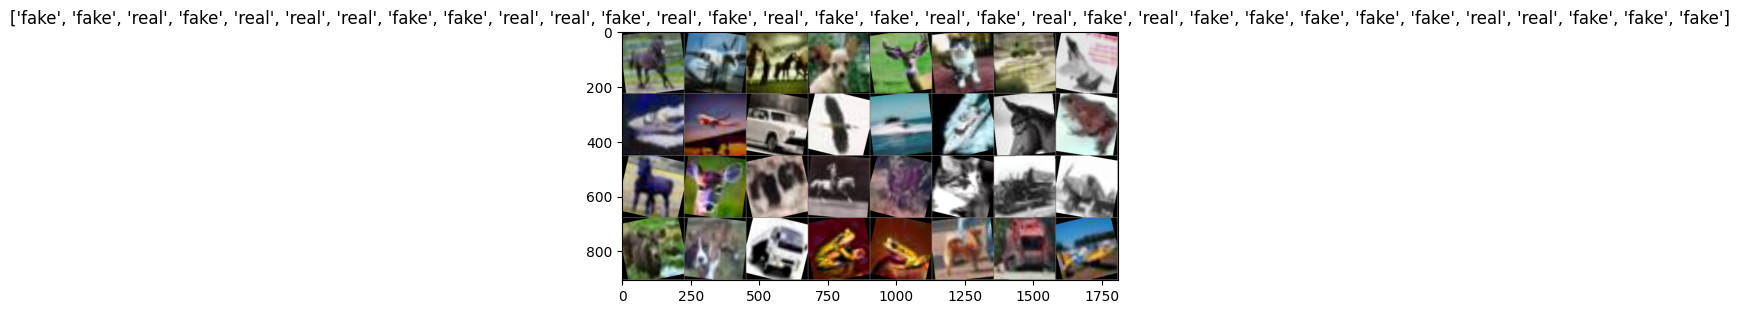

In [9]:
# --- Visualize a Batch (Optional) ---

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

# Get a batch of training data
try:
    inputs, classes = next(iter(train_loader))
    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    
    class_names = ['real', 'fake']
    imshow(out, title=[class_names[int(x)] for x in classes])
except StopIteration:
    print("Train loader is empty. This might happen with very small datasets.")

In [10]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, patience, model_save_path):
    """
    Main training and validation loop with early stopping.
    """
    
    if DEVICE == "cuda":
        torch.cuda.reset_peak_memory_stats(DEVICE)
        
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}
    
    best_model_state = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # --- Training Phase ---
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE).unsqueeze(1) # Match shape for BCEWithLogitsLoss [batch_size, 1]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects += torch.sum(preds == (labels > 0.5))
            train_total += labels.size(0)

        epoch_train_loss = running_loss / train_total
        epoch_train_acc = running_corrects.double() / train_total
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')

        # --- Validation Phase ---
        model.eval()   # Set model to evaluate mode
        running_val_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE).unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs) > 0.5
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        # Calculate validation metrics
        if len(all_labels) > 0:
            val_total = len(all_labels)
            epoch_val_loss = running_val_loss / val_total
            
            # Convert lists of arrays to a single flat array for sklearn
            all_labels = np.array(all_labels).flatten()
            all_preds = np.array(all_preds).flatten()

            epoch_val_acc = accuracy_score(all_labels, all_preds)
            # Use zero_division=0 to handle cases with no positive predictions/labels
            epoch_val_precision = precision_score(all_labels, all_preds, zero_division=0)
            epoch_val_recall = recall_score(all_labels, all_preds, zero_division=0)
            epoch_val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        else:
            print("Validation set is empty. Skipping metrics.")
            epoch_val_loss = 0.0
            epoch_val_acc = 0.0
            epoch_val_precision = 0.0
            epoch_val_recall = 0.0
            epoch_val_f1 = 0.0
            
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_precision'].append(epoch_val_precision)
        history['val_recall'].append(epoch_val_recall)
        history['val_f1'].append(epoch_val_f1)

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
        print(f'Val Precision: {epoch_val_precision:.4f} Recall: {epoch_val_recall:.4f} F1: {epoch_val_f1:.4f}')

        # --- Early Stopping Check ---
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, model_save_path)
            model_size_mb = os.path.getsize(model_save_path) / (1024 * 1024)
            print(f"New best model saved to {model_save_path} (Size: {model_size_mb:.2f} MB)")
            early_stopping_counter = 0
        else:
            if early_stopping_counter >= patience:
                print("Early stopping triggered")
                break

    end_time = time.time()
    total_duration_sec = end_time - start_time
    print(f'\nTraining complete in {total_duration_sec // 60:.0f}m {total_duration_sec % 60:.0f}s')
    print(f'Best val Loss: {best_val_loss:4f}')
    
    if DEVICE == "cuda":
        peak_mem_mb = torch.cuda.max_memory_allocated(DEVICE) / (1024 * 1024)
        print(f'Peak GPU memory allocated during training: {peak_mem_mb:.2f} MB')
    
    # Load best model weights back
    model.load_state_dict(torch.load(model_save_path))
    
    return history, total_duration_sec


In [11]:
def plot_history(history, title):
    """Plots training and validation metrics."""
    plt.figure(figsize=(12, 8))
    
    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{title} - Loss')

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend()
    plt.title(f'{title} - Accuracy')

    # Plot Precision & Recall
    plt.subplot(2, 2, 3)
    plt.plot(history['val_precision'], label='Val Precision')
    plt.plot(history['val_recall'], label='Val Recall')
    plt.legend()
    plt.title(f'{title} - Precision & Recall')

    # Plot F1-Score
    plt.subplot(2, 2, 4)
    plt.plot(history['val_f1'], label='Val F1-Score')
    plt.legend()
    plt.title(f'{title} - F1-Score')

    plt.tight_layout()
    plt.show()

--- Training Model 1: ResNet-50 ---


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


ResNet-50: 4.13 GFLOPs, 23.51 MParams
Epoch 1/35
----------


Training: 100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


Train Loss: 0.6217 Acc: 0.7050


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.51it/s]


Val Loss: 0.5898 Acc: 0.7650
Val Precision: 0.8618 Recall: 0.5792 F1: 0.6928
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 2/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s]


Train Loss: 0.5264 Acc: 0.7831


Validation: 100%|██████████| 13/13 [00:00<00:00, 13.96it/s]


Val Loss: 0.5399 Acc: 0.7825
Val Precision: 0.9068 Recall: 0.5847 F1: 0.7110
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 3/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.62it/s]


Train Loss: 0.4914 Acc: 0.8013


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.52it/s]


Val Loss: 0.5016 Acc: 0.8000
Val Precision: 0.8084 Recall: 0.7377 F1: 0.7714
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 4/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s]


Train Loss: 0.4596 Acc: 0.8069


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.30it/s]


Val Loss: 0.4819 Acc: 0.8050
Val Precision: 0.8221 Recall: 0.7322 F1: 0.7746
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 5/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s]


Train Loss: 0.4297 Acc: 0.8287


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.06it/s]


Val Loss: 0.4664 Acc: 0.8075
Val Precision: 0.8630 Recall: 0.6885 F1: 0.7660
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 6/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.35it/s]


Train Loss: 0.4139 Acc: 0.8294


Validation: 100%|██████████| 13/13 [00:00<00:00, 13.77it/s]


Val Loss: 0.4526 Acc: 0.8200
Val Precision: 0.8066 Recall: 0.7978 F1: 0.8022
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 7/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s]


Train Loss: 0.4099 Acc: 0.8200


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.24it/s]


Val Loss: 0.4377 Acc: 0.8150
Val Precision: 0.8225 Recall: 0.7596 F1: 0.7898
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 8/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


Train Loss: 0.3944 Acc: 0.8375


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.34it/s]


Val Loss: 0.4358 Acc: 0.8300
Val Precision: 0.8286 Recall: 0.7923 F1: 0.8101
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 9/35
----------


Training: 100%|██████████| 50/50 [00:08<00:00,  6.25it/s]


Train Loss: 0.3758 Acc: 0.8519


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.49it/s]


Val Loss: 0.4205 Acc: 0.8225
Val Precision: 0.8218 Recall: 0.7814 F1: 0.8011
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 10/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Train Loss: 0.3754 Acc: 0.8538


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.27it/s]


Val Loss: 0.4178 Acc: 0.8300
Val Precision: 0.8142 Recall: 0.8142 F1: 0.8142
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 11/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.75it/s]


Train Loss: 0.3796 Acc: 0.8281


Validation: 100%|██████████| 13/13 [00:00<00:00, 13.02it/s]


Val Loss: 0.4080 Acc: 0.8275
Val Precision: 0.8353 Recall: 0.7760 F1: 0.8045
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 12/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


Train Loss: 0.3624 Acc: 0.8519


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.65it/s]


Val Loss: 0.4048 Acc: 0.8325
Val Precision: 0.8452 Recall: 0.7760 F1: 0.8091
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 13/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.43it/s]


Train Loss: 0.3641 Acc: 0.8506


Validation: 100%|██████████| 13/13 [00:01<00:00, 12.89it/s]


Val Loss: 0.4013 Acc: 0.8325
Val Precision: 0.8085 Recall: 0.8306 F1: 0.8194
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 14/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]


Train Loss: 0.3529 Acc: 0.8450


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.54it/s]


Val Loss: 0.3942 Acc: 0.8475
Val Precision: 0.8352 Recall: 0.8306 F1: 0.8329
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 15/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


Train Loss: 0.3352 Acc: 0.8669


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.81it/s]


Val Loss: 0.3878 Acc: 0.8325
Val Precision: 0.8258 Recall: 0.8033 F1: 0.8144
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 16/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.40it/s]


Train Loss: 0.3499 Acc: 0.8606


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.35it/s]


Val Loss: 0.3856 Acc: 0.8500
Val Precision: 0.8917 Recall: 0.7650 F1: 0.8235
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 17/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.47it/s]


Train Loss: 0.3460 Acc: 0.8600


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.58it/s]


Val Loss: 0.3824 Acc: 0.8425
Val Precision: 0.8448 Recall: 0.8033 F1: 0.8235
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 18/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.77it/s]


Train Loss: 0.3406 Acc: 0.8725


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.45it/s]


Val Loss: 0.3832 Acc: 0.8275
Val Precision: 0.8065 Recall: 0.8197 F1: 0.8130
Epoch 19/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.46it/s]


Train Loss: 0.3447 Acc: 0.8631


Validation: 100%|██████████| 13/13 [00:00<00:00, 13.66it/s]


Val Loss: 0.3862 Acc: 0.8425
Val Precision: 0.8409 Recall: 0.8087 F1: 0.8245
Epoch 20/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.81it/s]


Train Loss: 0.3344 Acc: 0.8656


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.14it/s]


Val Loss: 0.3775 Acc: 0.8625
Val Precision: 0.8516 Recall: 0.8470 F1: 0.8493
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 21/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.40it/s]


Train Loss: 0.3475 Acc: 0.8550


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.41it/s]


Val Loss: 0.3779 Acc: 0.8450
Val Precision: 0.8805 Recall: 0.7650 F1: 0.8187
Epoch 22/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


Train Loss: 0.3399 Acc: 0.8525


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.11it/s]


Val Loss: 0.3821 Acc: 0.8275
Val Precision: 0.7969 Recall: 0.8361 F1: 0.8160
Epoch 23/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


Train Loss: 0.3245 Acc: 0.8738


Validation: 100%|██████████| 13/13 [00:00<00:00, 13.09it/s]


Val Loss: 0.3789 Acc: 0.8425
Val Precision: 0.8797 Recall: 0.7596 F1: 0.8152
Epoch 24/35
----------


Training: 100%|██████████| 50/50 [00:08<00:00,  6.11it/s]


Train Loss: 0.3149 Acc: 0.8675


Validation: 100%|██████████| 13/13 [00:00<00:00, 13.96it/s]


Val Loss: 0.3751 Acc: 0.8475
Val Precision: 0.8720 Recall: 0.7814 F1: 0.8242
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 25/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s]


Train Loss: 0.3204 Acc: 0.8675


Validation: 100%|██████████| 13/13 [00:00<00:00, 13.22it/s]


Val Loss: 0.3718 Acc: 0.8400
Val Precision: 0.8940 Recall: 0.7377 F1: 0.8084
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 26/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


Train Loss: 0.3253 Acc: 0.8613


Validation: 100%|██████████| 13/13 [00:01<00:00, 12.98it/s]


Val Loss: 0.3697 Acc: 0.8525
Val Precision: 0.8605 Recall: 0.8087 F1: 0.8338
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 27/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.80it/s]


Train Loss: 0.3144 Acc: 0.8825


Validation: 100%|██████████| 13/13 [00:00<00:00, 13.33it/s]


Val Loss: 0.3688 Acc: 0.8500
Val Precision: 0.8727 Recall: 0.7869 F1: 0.8276
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 28/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


Train Loss: 0.3194 Acc: 0.8738


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.06it/s]


Val Loss: 0.3734 Acc: 0.8300
Val Precision: 0.8010 Recall: 0.8361 F1: 0.8182
Epoch 29/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


Train Loss: 0.3093 Acc: 0.8725


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.93it/s]


Val Loss: 0.3766 Acc: 0.8425
Val Precision: 0.9000 Recall: 0.7377 F1: 0.8108
Epoch 30/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s]


Train Loss: 0.3099 Acc: 0.8706


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.04it/s]


Val Loss: 0.3668 Acc: 0.8400
Val Precision: 0.8480 Recall: 0.7923 F1: 0.8192
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 31/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


Train Loss: 0.3114 Acc: 0.8812


Validation: 100%|██████████| 13/13 [00:01<00:00, 12.73it/s]


Val Loss: 0.3654 Acc: 0.8425
Val Precision: 0.8571 Recall: 0.7869 F1: 0.8205
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 32/35
----------


Training: 100%|██████████| 50/50 [00:08<00:00,  6.21it/s]


Train Loss: 0.3055 Acc: 0.8762


Validation: 100%|██████████| 13/13 [00:00<00:00, 13.02it/s]


Val Loss: 0.3610 Acc: 0.8375
Val Precision: 0.8278 Recall: 0.8142 F1: 0.8209
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 33/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.77it/s]


Train Loss: 0.3162 Acc: 0.8606


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.13it/s]


Val Loss: 0.3607 Acc: 0.8325
Val Precision: 0.8053 Recall: 0.8361 F1: 0.8204
New best model saved to best_resnet.pth (Size: 90.00 MB)
Epoch 34/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s]


Train Loss: 0.3077 Acc: 0.8806


Validation: 100%|██████████| 13/13 [00:01<00:00, 12.66it/s]


Val Loss: 0.3607 Acc: 0.8500
Val Precision: 0.8514 Recall: 0.8142 F1: 0.8324
Epoch 35/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.47it/s]


Train Loss: 0.3087 Acc: 0.8744


Validation: 100%|██████████| 13/13 [00:01<00:00, 12.11it/s]


Val Loss: 0.3547 Acc: 0.8550
Val Precision: 0.8613 Recall: 0.8142 F1: 0.8371
New best model saved to best_resnet.pth (Size: 90.00 MB)

Training complete in 5m 8s
Best val Loss: 0.354689
Peak GPU memory allocated during training: 1172.01 MB


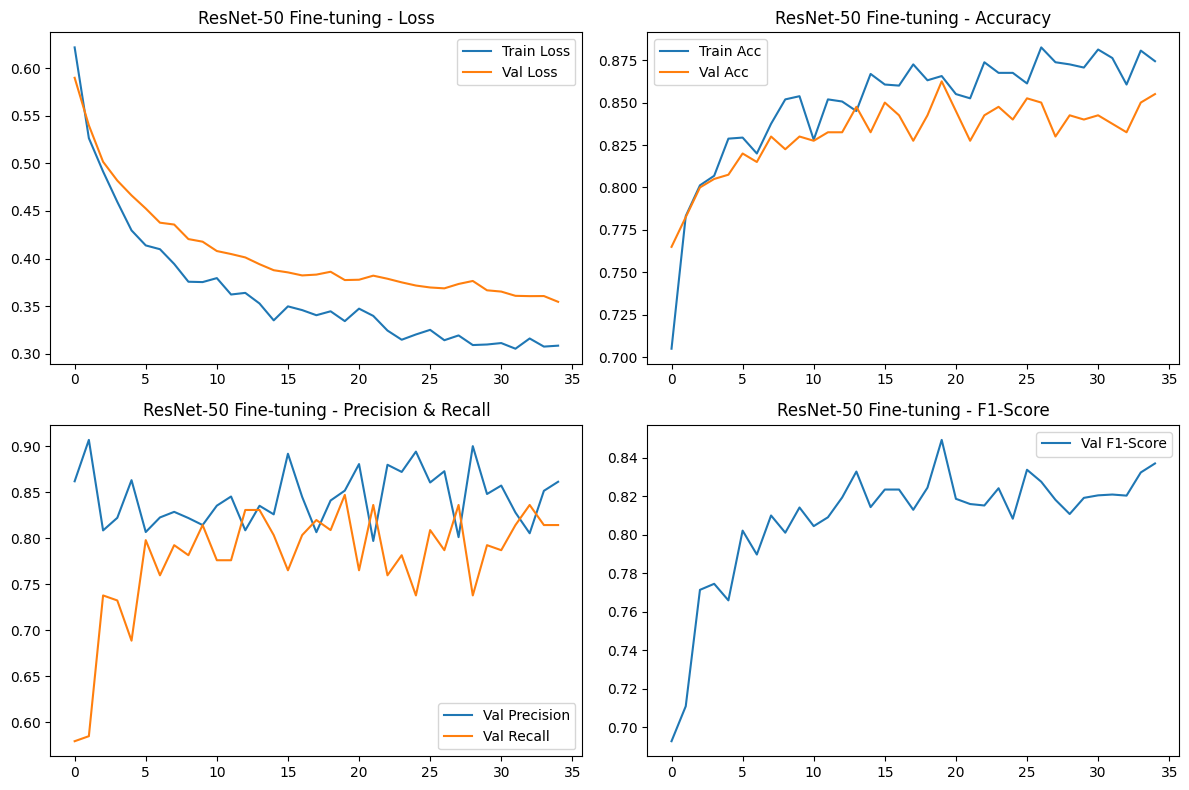

In [12]:
print("--- Training Model 1: ResNet-50 ---")

# 1. Load pre-trained model
model_resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# 2. Freeze all parameters
for param in model_resnet.parameters():
    param.requires_grad = False

# 3. Replace the final layer
# We output 1 logit for BCEWithLogitsLoss
in_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_features, 1)

# 4. Move model to device
model_resnet = model_resnet.to(DEVICE)

# 5. Calculate FLOPs and Params
try:
    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
    flops, params = profile(model_resnet, inputs=(dummy_input, ), verbose=False)
    print(f"ResNet-50: {flops/1e9:.2f} GFLOPs, {params/1e6:.2f} MParams")
except Exception as e:
    print(f"Could not calculate FLOPs for ResNet-50: {e}")
    
# 6. Define Loss and Optimizer
# We only optimize the parameters of the new final layer
criterion = nn.BCEWithLogitsLoss() # Includes sigmoid, numerically stable
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=LEARNING_RATE)

# 7. Train the model
resnet_history, resnet_time = train_model(model_resnet, criterion, optimizer_resnet, train_loader, val_loader, 
                                          num_epochs=NUM_EPOCHS, patience=PATIENCE, model_save_path=RESNET_PATH)

# 8. Plot history
plot_history(resnet_history, "ResNet-50 Fine-tuning")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


--- Training Model 2: EfficientNet-B0 ---


100%|██████████| 20.5M/20.5M [00:00<00:00, 167MB/s]


EfficientNet-B0: 0.41 GFLOPs, 4.01 MParams
Epoch 1/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


Train Loss: 0.5938 Acc: 0.7288


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.55it/s]


Val Loss: 0.5452 Acc: 0.7325
Val Precision: 0.8585 Recall: 0.4973 F1: 0.6298
New best model saved to best_efficientnet.pth (Size: 15.68 MB)
Epoch 2/35
----------


Training: 100%|██████████| 50/50 [00:06<00:00,  7.21it/s]


Train Loss: 0.4839 Acc: 0.8025


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.94it/s]


Val Loss: 0.5054 Acc: 0.7500
Val Precision: 0.8739 Recall: 0.5301 F1: 0.6599
New best model saved to best_efficientnet.pth (Size: 15.68 MB)
Epoch 3/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Train Loss: 0.4513 Acc: 0.8056


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.92it/s]


Val Loss: 0.5105 Acc: 0.7200
Val Precision: 0.8817 Recall: 0.4481 F1: 0.5942
Epoch 4/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Train Loss: 0.4317 Acc: 0.8100


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.93it/s]


Val Loss: 0.4767 Acc: 0.7800
Val Precision: 0.9060 Recall: 0.5792 F1: 0.7067
New best model saved to best_efficientnet.pth (Size: 15.68 MB)
Epoch 5/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s]


Train Loss: 0.3972 Acc: 0.8281


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.48it/s]


Val Loss: 0.4639 Acc: 0.7825
Val Precision: 0.8692 Recall: 0.6175 F1: 0.7220
New best model saved to best_efficientnet.pth (Size: 15.68 MB)
Epoch 6/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]


Train Loss: 0.3844 Acc: 0.8413


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.57it/s]


Val Loss: 0.4570 Acc: 0.7825
Val Precision: 0.8636 Recall: 0.6230 F1: 0.7238
New best model saved to best_efficientnet.pth (Size: 15.68 MB)
Epoch 7/35
----------


Training: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s]


Train Loss: 0.4009 Acc: 0.8169


Validation: 100%|██████████| 13/13 [00:00<00:00, 17.07it/s]


Val Loss: 0.4426 Acc: 0.7950
Val Precision: 0.8483 Recall: 0.6721 F1: 0.7500
New best model saved to best_efficientnet.pth (Size: 15.68 MB)
Epoch 8/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


Train Loss: 0.3875 Acc: 0.8181


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.30it/s]


Val Loss: 0.4441 Acc: 0.7825
Val Precision: 0.8429 Recall: 0.6448 F1: 0.7307
Epoch 9/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Train Loss: 0.3964 Acc: 0.8294


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.67it/s]


Val Loss: 0.4559 Acc: 0.7725
Val Precision: 0.8651 Recall: 0.5956 F1: 0.7055
Epoch 10/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Train Loss: 0.3737 Acc: 0.8344


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.29it/s]


Val Loss: 0.4575 Acc: 0.7700
Val Precision: 0.8760 Recall: 0.5792 F1: 0.6974
Epoch 11/35
----------


Training: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s]


Train Loss: 0.3738 Acc: 0.8394


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.89it/s]


Val Loss: 0.4547 Acc: 0.7800
Val Precision: 0.8740 Recall: 0.6066 F1: 0.7161
Epoch 12/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


Train Loss: 0.3663 Acc: 0.8425


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.59it/s]


Val Loss: 0.4593 Acc: 0.7775
Val Precision: 0.8852 Recall: 0.5902 F1: 0.7082
Epoch 13/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]


Train Loss: 0.3578 Acc: 0.8488


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.48it/s]


Val Loss: 0.4424 Acc: 0.7950
Val Precision: 0.8855 Recall: 0.6339 F1: 0.7389
New best model saved to best_efficientnet.pth (Size: 15.68 MB)
Epoch 14/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.03it/s]


Train Loss: 0.3483 Acc: 0.8475


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.86it/s]


Val Loss: 0.4527 Acc: 0.7800
Val Precision: 0.8862 Recall: 0.5956 F1: 0.7124
Epoch 15/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.82it/s]


Train Loss: 0.3358 Acc: 0.8538


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.17it/s]


Val Loss: 0.4458 Acc: 0.7925
Val Precision: 0.8788 Recall: 0.6339 F1: 0.7365
Epoch 16/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s]


Train Loss: 0.3678 Acc: 0.8375


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.02it/s]


Val Loss: 0.4518 Acc: 0.7825
Val Precision: 0.8636 Recall: 0.6230 F1: 0.7238
Epoch 17/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Train Loss: 0.3849 Acc: 0.8400


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.30it/s]


Val Loss: 0.4213 Acc: 0.8075
Val Precision: 0.8442 Recall: 0.7104 F1: 0.7715
New best model saved to best_efficientnet.pth (Size: 15.68 MB)
Epoch 18/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Train Loss: 0.3799 Acc: 0.8350


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.46it/s]


Val Loss: 0.4136 Acc: 0.8225
Val Precision: 0.8544 Recall: 0.7377 F1: 0.7918
New best model saved to best_efficientnet.pth (Size: 15.68 MB)
Epoch 19/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.03it/s]


Train Loss: 0.3467 Acc: 0.8556


Validation: 100%|██████████| 13/13 [00:00<00:00, 17.13it/s]


Val Loss: 0.4300 Acc: 0.8025
Val Precision: 0.8768 Recall: 0.6612 F1: 0.7539
Epoch 20/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.03it/s]


Train Loss: 0.3344 Acc: 0.8606


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.88it/s]


Val Loss: 0.4248 Acc: 0.8150
Val Precision: 0.8562 Recall: 0.7158 F1: 0.7798
Epoch 21/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]


Train Loss: 0.3433 Acc: 0.8494


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.48it/s]


Val Loss: 0.4278 Acc: 0.8050
Val Precision: 0.8671 Recall: 0.6776 F1: 0.7607
Epoch 22/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.09it/s]


Train Loss: 0.3455 Acc: 0.8519


Validation: 100%|██████████| 13/13 [00:00<00:00, 17.26it/s]


Val Loss: 0.4515 Acc: 0.7900
Val Precision: 0.8898 Recall: 0.6175 F1: 0.7290
Epoch 23/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Train Loss: 0.3726 Acc: 0.8356


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.65it/s]


Val Loss: 0.4239 Acc: 0.8125
Val Precision: 0.8649 Recall: 0.6995 F1: 0.7734
Epoch 24/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Train Loss: 0.3594 Acc: 0.8369


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.28it/s]


Val Loss: 0.4218 Acc: 0.8075
Val Precision: 0.8397 Recall: 0.7158 F1: 0.7729
Epoch 25/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Train Loss: 0.3668 Acc: 0.8337


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.47it/s]


Val Loss: 0.4562 Acc: 0.7925
Val Precision: 0.8846 Recall: 0.6284 F1: 0.7348
Epoch 26/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


Train Loss: 0.3437 Acc: 0.8556


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.50it/s]


Val Loss: 0.4191 Acc: 0.8075
Val Precision: 0.8630 Recall: 0.6885 F1: 0.7660
Epoch 27/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.04it/s]


Train Loss: 0.3229 Acc: 0.8706


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.22it/s]


Val Loss: 0.4341 Acc: 0.7975
Val Precision: 0.8592 Recall: 0.6667 F1: 0.7508
Epoch 28/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Train Loss: 0.3558 Acc: 0.8469


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.90it/s]


Val Loss: 0.4293 Acc: 0.8025
Val Precision: 0.8467 Recall: 0.6940 F1: 0.7628
Epoch 29/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]


Train Loss: 0.3530 Acc: 0.8481


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.23it/s]


Val Loss: 0.4275 Acc: 0.8075
Val Precision: 0.8630 Recall: 0.6885 F1: 0.7660
Epoch 30/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


Train Loss: 0.3392 Acc: 0.8613


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.84it/s]


Val Loss: 0.4126 Acc: 0.8150
Val Precision: 0.8658 Recall: 0.7049 F1: 0.7771
New best model saved to best_efficientnet.pth (Size: 15.68 MB)
Epoch 31/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.77it/s]


Train Loss: 0.3356 Acc: 0.8506


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.31it/s]


Val Loss: 0.4261 Acc: 0.8100
Val Precision: 0.8497 Recall: 0.7104 F1: 0.7738
Epoch 32/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


Train Loss: 0.3647 Acc: 0.8425


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.40it/s]


Val Loss: 0.4438 Acc: 0.8050
Val Precision: 0.8832 Recall: 0.6612 F1: 0.7562
Epoch 33/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


Train Loss: 0.3462 Acc: 0.8538


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.61it/s]


Val Loss: 0.4431 Acc: 0.7950
Val Precision: 0.8633 Recall: 0.6557 F1: 0.7453
Epoch 34/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.09it/s]


Train Loss: 0.3309 Acc: 0.8525


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.62it/s]


Val Loss: 0.4325 Acc: 0.8150
Val Precision: 0.8865 Recall: 0.6831 F1: 0.7716
Epoch 35/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Train Loss: 0.3417 Acc: 0.8519


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.95it/s]


Val Loss: 0.4320 Acc: 0.8100
Val Precision: 0.8741 Recall: 0.6831 F1: 0.7669

Training complete in 4m 40s
Best val Loss: 0.412616
Peak GPU memory allocated during training: 1050.11 MB


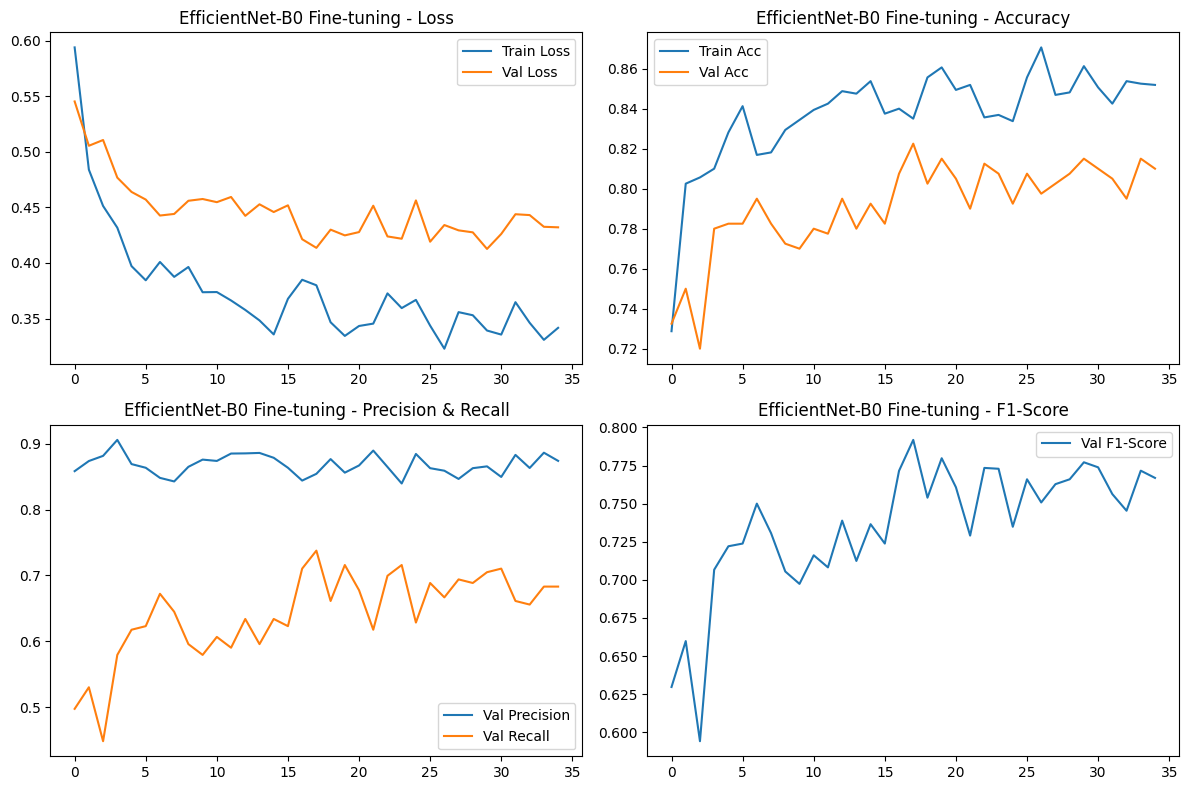

In [13]:
print("--- Training Model 2: EfficientNet-B0 ---")

# 1. Load pre-trained model
model_efficientnet = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

# 2. Freeze all parameters
for param in model_efficientnet.parameters():
    param.requires_grad = False

# 3. Replace the final layer
in_features = model_efficientnet.classifier[1].in_features
model_efficientnet.classifier[1] = nn.Linear(in_features, 1)

# 4. Move model to device
model_efficientnet = model_efficientnet.to(DEVICE)

# 5. Calculate FLOPs and Params
try:
    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
    flops, params = profile(model_efficientnet, inputs=(dummy_input, ), verbose=False)
    print(f"EfficientNet-B0: {flops/1e9:.2f} GFLOPs, {params/1e6:.2f} MParams")
except Exception as e:
    print(f"Could not calculate FLOPs for EfficientNet-B0: {e}")

# 6. Define Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_efficientnet = optim.Adam(model_efficientnet.classifier.parameters(), lr=LEARNING_RATE)

# 7. Train the model
efficientnet_history, efficientnet_time = train_model(model_efficientnet, criterion, optimizer_efficientnet, train_loader, val_loader, 
                                                    num_epochs=NUM_EPOCHS, patience=PATIENCE, model_save_path=EFFICIENTNET_PATH)

# 8. Plot history
plot_history(efficientnet_history, "EfficientNet-B0 Fine-tuning")

In [14]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # Input: [B, 3, 224, 224]
        self.conv1 = self._conv_block(3, 16, 3, 1, 1) # -> [B, 16, 112, 112]
        self.conv2 = self._conv_block(16, 32, 3, 1, 1) # -> [B, 32, 56, 56]
        self.conv3 = self._conv_block(32, 64, 3, 1, 1) # -> [B, 64, 28, 28]
        self.conv4 = self._conv_block(64, 128, 3, 1, 1) # -> [B, 128, 14, 14]
        
        self.flatten = nn.Flatten()
        
        self.fc1 = self._fc_block(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 1) # Output logit

    def _conv_block(self, in_channels, out_channels, kernel, stride, padding):
        """A repeating convolutional block."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(), # GELU is often preferred over ReLU in modern architectures
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
    def _fc_block(self, in_features, out_features):
        """A repeating fully-connected block."""
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.GELU(),
            nn.Dropout(0.5) # Regularization
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


--- Training Model 3: Custom CNN ---
CustomCNN: 0.21 GFLOPs, 12.94 MParams
Epoch 1/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Train Loss: 0.5592 Acc: 0.7131


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.13it/s]


Val Loss: 0.4417 Acc: 0.8000
Val Precision: 0.7512 Recall: 0.8415 F1: 0.7938
New best model saved to best_custom_cnn.pth (Size: 49.40 MB)
Epoch 2/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


Train Loss: 0.4636 Acc: 0.7800


Validation: 100%|██████████| 13/13 [00:00<00:00, 17.37it/s]


Val Loss: 0.5033 Acc: 0.7300
Val Precision: 0.8319 Recall: 0.5137 F1: 0.6351
Epoch 3/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.10it/s]


Train Loss: 0.4227 Acc: 0.8019


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.82it/s]


Val Loss: 0.4581 Acc: 0.7900
Val Precision: 0.8322 Recall: 0.6776 F1: 0.7470
Epoch 4/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


Train Loss: 0.3866 Acc: 0.8156


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.90it/s]


Val Loss: 0.4005 Acc: 0.8300
Val Precision: 0.8042 Recall: 0.8306 F1: 0.8172
New best model saved to best_custom_cnn.pth (Size: 49.40 MB)
Epoch 5/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Train Loss: 0.3440 Acc: 0.8363


Validation: 100%|██████████| 13/13 [00:00<00:00, 17.72it/s]


Val Loss: 0.4788 Acc: 0.7725
Val Precision: 0.8538 Recall: 0.6066 F1: 0.7093
Epoch 6/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


Train Loss: 0.3546 Acc: 0.8531


Validation: 100%|██████████| 13/13 [00:00<00:00, 18.28it/s]


Val Loss: 0.3918 Acc: 0.8225
Val Precision: 0.8182 Recall: 0.7869 F1: 0.8022
New best model saved to best_custom_cnn.pth (Size: 49.40 MB)
Epoch 7/35
----------


Training: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s]


Train Loss: 0.3351 Acc: 0.8519


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.33it/s]


Val Loss: 0.3529 Acc: 0.8375
Val Precision: 0.7658 Recall: 0.9290 F1: 0.8395
New best model saved to best_custom_cnn.pth (Size: 49.40 MB)
Epoch 8/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Train Loss: 0.2920 Acc: 0.8706


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.91it/s]


Val Loss: 0.3433 Acc: 0.8600
Val Precision: 0.8470 Recall: 0.8470 F1: 0.8470
New best model saved to best_custom_cnn.pth (Size: 49.40 MB)
Epoch 9/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


Train Loss: 0.2948 Acc: 0.8819


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.49it/s]


Val Loss: 0.2914 Acc: 0.8650
Val Precision: 0.8342 Recall: 0.8798 F1: 0.8564
New best model saved to best_custom_cnn.pth (Size: 49.40 MB)
Epoch 10/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


Train Loss: 0.2611 Acc: 0.8894


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.58it/s]


Val Loss: 0.3106 Acc: 0.8650
Val Precision: 0.8377 Recall: 0.8743 F1: 0.8556
Epoch 11/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]


Train Loss: 0.2701 Acc: 0.8844


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.92it/s]


Val Loss: 0.2753 Acc: 0.8750
Val Precision: 0.8844 Recall: 0.8361 F1: 0.8596
New best model saved to best_custom_cnn.pth (Size: 49.40 MB)
Epoch 12/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s]


Train Loss: 0.2499 Acc: 0.8919


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.65it/s]


Val Loss: 0.2837 Acc: 0.8825
Val Precision: 0.8366 Recall: 0.9235 F1: 0.8779
Epoch 13/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


Train Loss: 0.2278 Acc: 0.9088


Validation: 100%|██████████| 13/13 [00:00<00:00, 17.05it/s]


Val Loss: 0.2582 Acc: 0.8925
Val Precision: 0.9023 Recall: 0.8579 F1: 0.8796
New best model saved to best_custom_cnn.pth (Size: 49.40 MB)
Epoch 14/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.06it/s]


Train Loss: 0.2305 Acc: 0.9088


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.20it/s]


Val Loss: 0.2705 Acc: 0.8825
Val Precision: 0.8333 Recall: 0.9290 F1: 0.8786
Epoch 15/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.82it/s]


Train Loss: 0.1903 Acc: 0.9250


Validation: 100%|██████████| 13/13 [00:00<00:00, 17.38it/s]


Val Loss: 0.2772 Acc: 0.9025
Val Precision: 0.9000 Recall: 0.8852 F1: 0.8926
Epoch 16/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


Train Loss: 0.2187 Acc: 0.9000


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.40it/s]


Val Loss: 0.3153 Acc: 0.8850
Val Precision: 0.9255 Recall: 0.8142 F1: 0.8663
Epoch 17/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Train Loss: 0.1972 Acc: 0.9231


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.80it/s]


Val Loss: 0.2513 Acc: 0.8900
Val Precision: 0.8528 Recall: 0.9180 F1: 0.8842
New best model saved to best_custom_cnn.pth (Size: 49.40 MB)
Epoch 18/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Train Loss: 0.1844 Acc: 0.9275


Validation: 100%|██████████| 13/13 [00:00<00:00, 17.25it/s]


Val Loss: 0.2414 Acc: 0.8950
Val Precision: 0.8543 Recall: 0.9290 F1: 0.8901
New best model saved to best_custom_cnn.pth (Size: 49.40 MB)
Epoch 19/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.03it/s]


Train Loss: 0.1825 Acc: 0.9281


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.00it/s]


Val Loss: 0.3908 Acc: 0.8625
Val Precision: 0.9638 Recall: 0.7268 F1: 0.8287
Epoch 20/35
----------


Training: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


Train Loss: 0.1953 Acc: 0.9206


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.71it/s]


Val Loss: 0.3315 Acc: 0.8650
Val Precision: 0.8728 Recall: 0.8251 F1: 0.8483
Epoch 21/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]


Train Loss: 0.1548 Acc: 0.9444


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.85it/s]


Val Loss: 0.2985 Acc: 0.8800
Val Precision: 0.9193 Recall: 0.8087 F1: 0.8605
Epoch 22/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


Train Loss: 0.1418 Acc: 0.9469


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.97it/s]


Val Loss: 0.2586 Acc: 0.8950
Val Precision: 0.8895 Recall: 0.8798 F1: 0.8846
Epoch 23/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Train Loss: 0.1514 Acc: 0.9369


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.67it/s]


Val Loss: 0.2580 Acc: 0.9025
Val Precision: 0.8956 Recall: 0.8907 F1: 0.8932
Epoch 24/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


Train Loss: 0.1377 Acc: 0.9425


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.92it/s]


Val Loss: 0.2544 Acc: 0.9025
Val Precision: 0.8913 Recall: 0.8962 F1: 0.8937
Epoch 25/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


Train Loss: 0.1390 Acc: 0.9444


Validation: 100%|██████████| 13/13 [00:00<00:00, 15.77it/s]


Val Loss: 0.3978 Acc: 0.8650
Val Precision: 0.7867 Recall: 0.9672 F1: 0.8676
Epoch 26/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


Train Loss: 0.1344 Acc: 0.9537


Validation: 100%|██████████| 13/13 [00:00<00:00, 17.62it/s]


Val Loss: 0.2932 Acc: 0.8975
Val Precision: 0.8944 Recall: 0.8798 F1: 0.8871
Epoch 27/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.03it/s]


Train Loss: 0.1205 Acc: 0.9525


Validation: 100%|██████████| 13/13 [00:00<00:00, 14.42it/s]


Val Loss: 0.2577 Acc: 0.9075
Val Precision: 0.9101 Recall: 0.8852 F1: 0.8975
Epoch 28/35
----------


Training: 100%|██████████| 50/50 [00:06<00:00,  7.30it/s]


Train Loss: 0.1406 Acc: 0.9469


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.25it/s]


Val Loss: 0.2454 Acc: 0.9100
Val Precision: 0.9249 Recall: 0.8743 F1: 0.8989
Epoch 29/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


Train Loss: 0.1207 Acc: 0.9537


Validation: 100%|██████████| 13/13 [00:00<00:00, 18.09it/s]


Val Loss: 0.2945 Acc: 0.8925
Val Precision: 0.9023 Recall: 0.8579 F1: 0.8796
Epoch 30/35
----------


Training: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


Train Loss: 0.1293 Acc: 0.9487


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.81it/s]


Val Loss: 0.2999 Acc: 0.8850
Val Precision: 0.8586 Recall: 0.8962 F1: 0.8770
Epoch 31/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.14it/s]


Train Loss: 0.0887 Acc: 0.9744


Validation: 100%|██████████| 13/13 [00:00<00:00, 17.73it/s]


Val Loss: 0.2583 Acc: 0.9050
Val Precision: 0.8962 Recall: 0.8962 F1: 0.8962
Epoch 32/35
----------


Training: 100%|██████████| 50/50 [00:06<00:00,  7.27it/s]


Train Loss: 0.1148 Acc: 0.9569


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.23it/s]


Val Loss: 0.6010 Acc: 0.8100
Val Precision: 0.7149 Recall: 0.9727 F1: 0.8241
Epoch 33/35
----------


Training: 100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


Train Loss: 0.0981 Acc: 0.9644


Validation: 100%|██████████| 13/13 [00:00<00:00, 18.21it/s]


Val Loss: 0.2748 Acc: 0.8950
Val Precision: 0.8983 Recall: 0.8689 F1: 0.8833
Epoch 34/35
----------


Training: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


Train Loss: 0.0871 Acc: 0.9700


Validation: 100%|██████████| 13/13 [00:00<00:00, 17.26it/s]


Val Loss: 0.2882 Acc: 0.8975
Val Precision: 0.9128 Recall: 0.8579 F1: 0.8845
Epoch 35/35
----------


Training: 100%|██████████| 50/50 [00:07<00:00,  7.10it/s]


Train Loss: 0.0981 Acc: 0.9613


Validation: 100%|██████████| 13/13 [00:00<00:00, 16.21it/s]


Val Loss: 0.4913 Acc: 0.8400
Val Precision: 0.7554 Recall: 0.9617 F1: 0.8462

Training complete in 4m 39s
Best val Loss: 0.241364
Peak GPU memory allocated during training: 1933.40 MB


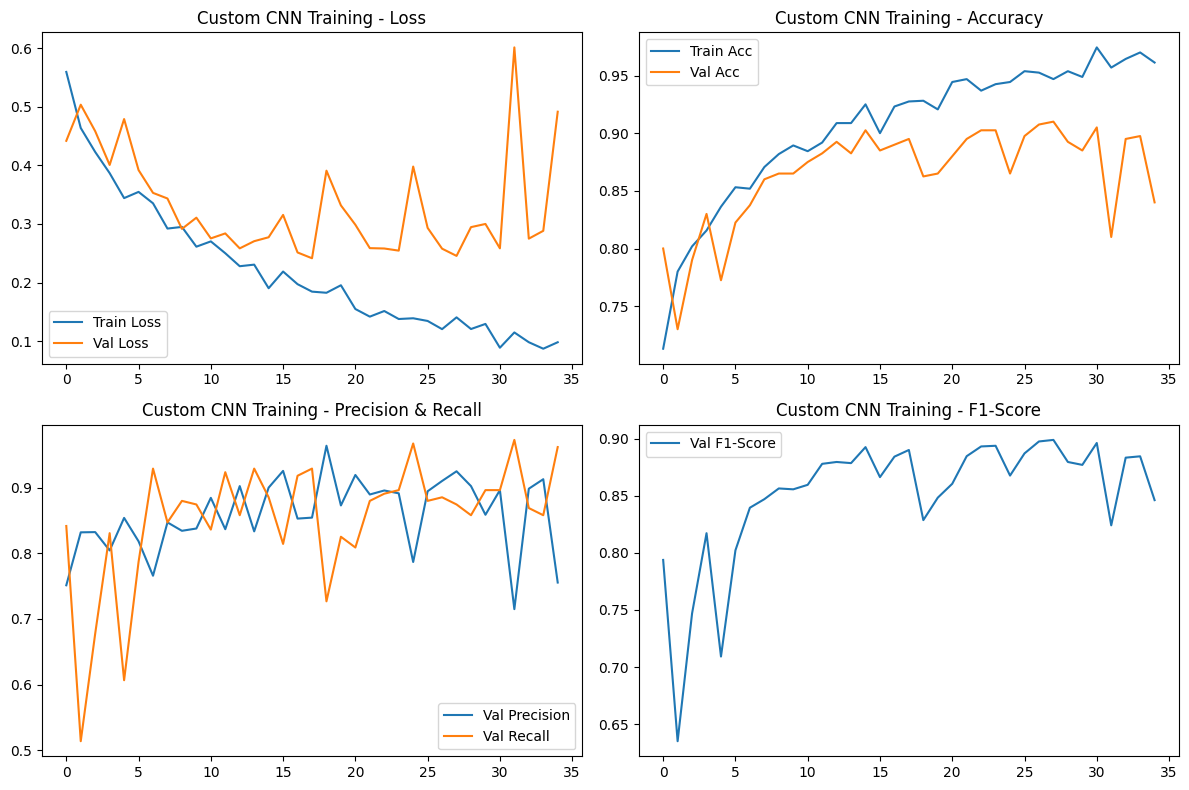

In [15]:
print("--- Training Model 3: Custom CNN ---")

# 1. Instantiate model
model_custom = CustomCNN().to(DEVICE)

# 2. Calculate FLOPs and Params
try:
    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
    flops, params = profile(model_custom, inputs=(dummy_input, ), verbose=False)
    print(f"CustomCNN: {flops/1e9:.2f} GFLOPs, {params/1e6:.2f} MParams")
except Exception as e:
    print(f"Could not calculate FLOPs for CustomCNN: {e}")

# 3. Define Loss and Optimizer
# We train all parameters from scratch
criterion = nn.BCEWithLogitsLoss()
optimizer_custom = optim.Adam(model_custom.parameters(), lr=LEARNING_RATE)

# 4. Train the model
custom_history, custom_time = train_model(model_custom, criterion, optimizer_custom, train_loader, val_loader, 
                                        num_epochs=NUM_EPOCHS, patience=PATIENCE, model_save_path=CUSTOM_CNN_PATH)

# 5. Plot history
plot_history(custom_history, "Custom CNN Training")

In [16]:
def generate_predictions(model, loader, device):
    """Runs inference on the test set and returns a prediction dictionary."""
    model.eval() # Set model to evaluation mode
    predictions = {}
    
    with torch.no_grad():
        for inputs, filenames in tqdm(loader, desc="Generating Predictions"):
            inputs = inputs.to(device)
            
            outputs = model(inputs)
            # Apply sigmoid to get probabilities (from 0 to 1)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            
            for filename, prob in zip(filenames, probs):
                # The requirement is probability of being a deepfake (label 1)
                predictions[filename] = float(prob)
                
    return predictions


In [17]:
print("--- Generating Final Predictions ---")

# --- ResNet Predictions ---
try:
    print("Loading best ResNet model for inference...")
    model_resnet.load_state_dict(torch.load(RESNET_PATH))
    resnet_preds = generate_predictions(model_resnet, test_loader, DEVICE)
    with open("resnet_predictions.json", "w") as f:
        json.dump(resnet_preds, f, indent=4)
    print("ResNet predictions saved to resnet_predictions.json")
except FileNotFoundError:
    print(f"Could not find {RESNET_PATH}. Skipping ResNet predictions.")
except Exception as e:
    print(f"Error generating ResNet predictions: {e}")

# --- EfficientNet Predictions ---
try:
    print("Loading best EfficientNet model for inference...")
    model_efficientnet.load_state_dict(torch.load(EFFICIENTNET_PATH))
    efficientnet_preds = generate_predictions(model_efficientnet, test_loader, DEVICE)
    with open("efficientnet_predictions.json", "w") as f:
        json.dump(efficientnet_preds, f, indent=4)
    print("EfficientNet predictions saved to efficientnet_predictions.json")
except FileNotFoundError:
    print(f"Could not find {EFFICIENTNET_PATH}. Skipping EfficientNet predictions.")
except Exception as e:
    print(f"Error generating EfficientNet predictions: {e}")

# --- Custom CNN Predictions ---
try:
    print("Loading best Custom CNN model for inference...")
    model_custom.load_state_dict(torch.load(CUSTOM_CNN_PATH))
    custom_preds = generate_predictions(model_custom, test_loader, DEVICE)
    with open("custom_cnn_predictions.json", "w") as f:
        json.dump(custom_preds, f, indent=4)
    print("Custom CNN predictions saved to custom_cnn_predictions.json")
except FileNotFoundError:
    print(f"Could not find {CUSTOM_CNN_PATH}. Skipping Custom CNN predictions.")
except Exception as e:
    print(f"Error generating Custom CNN predictions: {e}")


# Print a sample prediction from the first file (if it exists)
if 'resnet_preds' in locals() and resnet_preds:
    print("\n--- Sample ResNet Prediction ---")
    sample_key = list(resnet_preds.keys())[0]
    print(f"{sample_key}: {resnet_preds[sample_key]}")

--- Generating Final Predictions ---
Loading best ResNet model for inference...


Generating Predictions: 100%|██████████| 16/16 [00:01<00:00, 10.03it/s]


ResNet predictions saved to resnet_predictions.json
Loading best EfficientNet model for inference...


Generating Predictions: 100%|██████████| 16/16 [00:00<00:00, 16.46it/s]


EfficientNet predictions saved to efficientnet_predictions.json
Loading best Custom CNN model for inference...


Generating Predictions: 100%|██████████| 16/16 [00:00<00:00, 18.41it/s]

Custom CNN predictions saved to custom_cnn_predictions.json

--- Sample ResNet Prediction ---
173.png: 0.9525567293167114


In [18]:
# Clean up GPU memory
if DEVICE == "cuda":
    torch.cuda.empty_cache()